# MIS780 Advanced AI For Business - Assignment 2 - T2 2021

## Part C:  Deep Learning for Time Series Data

**Student Name:** Hoang Manh Nguyen

**Student ID:** 219380205

*Markdown formats: All tables and images will be aligned to the left. (Do not remove this code)*

In [ ]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

**Task Description**

1. Construct a Recurrent Neural Network for multivariate time series prediction.
2. Run this notebook and record results.
3. Generate prediction and compare with the original timeseries. 
4. Reflect on your experience gained in module 3 on Deep Learning


**NOTE: In your reponses below, you can create multiple Markdown and Code cells to present your work where needed. Remove the *instructional text in italic* and provide your explanations to the code procedures.**
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Table of Content
   
1. [Notebook Preparation](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Prediction](#cell_report)



<a id = "cell_Preparation"></a>
## 1. Notebook Preparation

We load all necessary Python libraries/packages (pandas, matplot + sns, sklearn, tensorflow keras)

Also, we develop code to run some common features, functions (graphs, data display) that will be used in later part

In [ ]:
# Load all necessary Python libraries/packages (pandas, matplot + sns, sklearn, tensorflow keras)

import os
import math

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD, Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2,l1,l1_l2
from tensorflow.keras.backend import square, mean
from tensorflow.keras.models import load_model

Some common features and functions


In [ ]:
# Create options to control display of information
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = [10, 5]

In [ ]:
# Code for displaying data frames side by side.
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [ ]:
# Collect history when running model
# Initiates collections of model performance
def start_hist():
    return {}
# Adds more performance indicators to history
def collect_hist(accum_hist, next_hist):
    # Get all keys
    keys = list(next_hist.keys())
    for k in keys:
        if k in accum_hist:
            accum_hist[k].extend(next_hist[k])
        else:
            accum_hist[k] = next_hist[k]
    return accum_hist

In [ ]:
# Plot history result of training model 
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

In [ ]:
# Plot data distribution using KDE method
def plot_distribution(df, field):
    plt.figure(figsize=(5,5))
    sns.kdeplot(df[field], alpha=0.8)
    plt.title(f'{field} Distribution')
    plt.xlabel(field)
    plt.ylabel('Probability')
    plt.show()

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

1. Load data file 

2. Preprocessing: 
- check statistics and information
- check missing values, remove blank rows
- format df
- draw data distribution of variables 
- check correlation coefficient


In [ ]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data file
Stock_price = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/A2/PartC-Stocks.csv")
Stock_price.set_index
print('Number of records read: ', Stock_price.size)
print('Stock_price shape: ', Stock_price.shape)
Stock_price.head()

Number of records read:  25160
Stock_price shape:  (2516, 10)


,Date,Day,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
0,1/4/10 12:00 AM,14612,23.819256,313.688690,30.950001,132.449997,20.879999,37.090000,133.899994,30.572857
1,1/5/10 12:00 AM,14613,23.919165,312.307312,30.959999,130.850006,20.870001,37.700001,134.690002,30.625713
2,1/6/10 12:00 AM,14614,23.696640,304.434448,30.770000,130.000000,20.799999,37.619999,132.250000,30.138571
3,1/7/10 12:00 AM,14615,23.705723,297.347351,30.450001,129.550003,20.600000,36.889999,130.000000,30.082857
4,1/8/10 12:00 AM,14616,23.882833,301.311310,30.660000,130.850006,20.830000,36.689999,133.520004,30.282858


In [ ]:
# Checking statistical summary
Stock_price.describe(include="all")

,Date,Day,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
count,2516,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
unique,2516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,8/3/15 12:00 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,16435.030604,16.078941,652.111853,56.322166,162.001892,32.489364,104.480763,676.207079,110.345293
std,NaN,1054.325591,4.776089,328.755875,33.863428,24.271917,10.704391,84.966762,580.440707,56.172958
min,NaN,14612.000000,5.317893,218.253250,23.010000,107.570000,17.670000,22.690001,108.610001,27.435715
25%,NaN,15521.250000,12.189729,317.869110,29.559999,143.037495,23.257500,34.274999,227.597496,64.714285
50%,NaN,16435.000000,15.887779,570.769989,44.400002,159.529999,30.860001,72.904999,375.140015,99.480000
75%,NaN,17346.750000,19.865320,947.542480,70.940002,184.007504,36.902501,143.597496,967.847488,150.552502


In [ ]:
# Check general information
Stock_price.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2516 non-null   object 
 1   Day     2516 non-null   int64  
 2   HPQ     2516 non-null   float64
 3   GOOGL   2516 non-null   float64
 4   MSFT    2516 non-null   float64
 5   IBM     2516 non-null   float64
 6   INTC    2516 non-null   float64
 7   ADBE    2516 non-null   float64
 8   AMZN    2516 non-null   float64
 9   AAPL    2516 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 196.7+ KB


In [ ]:
# Check missing values
print('Records:\t', len(Stock_price))
missing = Stock_price.isnull().sum()
print(missing.sort_values(ascending=False))

print("\n There are no missing values")

Records:	 2516
AAPL     0
AMZN     0
ADBE     0
INTC     0
IBM      0
MSFT     0
GOOGL    0
HPQ      0
Day      0
Date     0
dtype: int64

 There are no missing values


In [ ]:
# Remove all empty rows if needed
Stock_price = Stock_price.dropna(how='all')
    
# Create "Date" index
Stock_price['Date'] = pd.to_datetime(Stock_price['Date'])
Stock_price.index = Stock_price['Date']
Stock_price.sort_index(inplace=True)

# Drop "Date" and "Day" columns
Stock_price = Stock_price.drop(["Date", "Day"], axis=1)
Stock_price.head()

,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
Date,,,,,,,,
2010-01-04,23.819256,313.688690,30.950001,132.449997,20.879999,37.090000,133.899994,30.572857
2010-01-05,23.919165,312.307312,30.959999,130.850006,20.870001,37.700001,134.690002,30.625713
2010-01-06,23.696640,304.434448,30.770000,130.000000,20.799999,37.619999,132.250000,30.138571
2010-01-07,23.705723,297.347351,30.450001,129.550003,20.600000,36.889999,130.000000,30.082857
2010-01-08,23.882833,301.311310,30.660000,130.850006,20.830000,36.689999,133.520004,30.282858


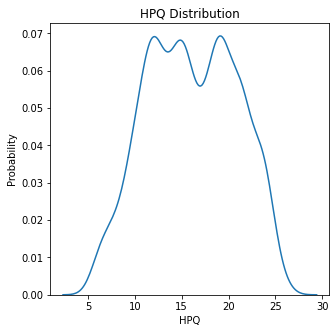

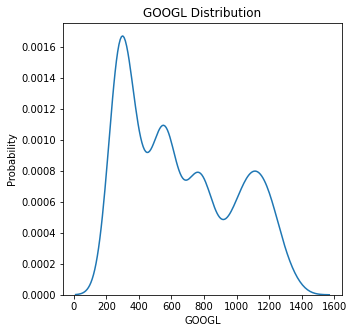

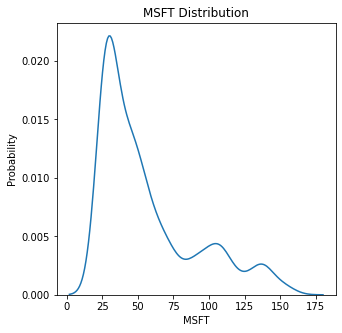

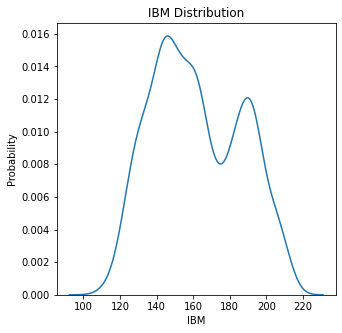

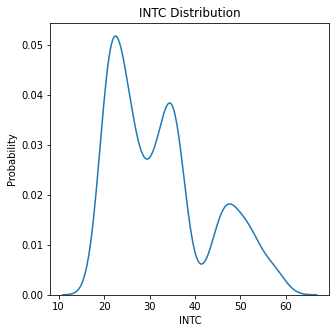

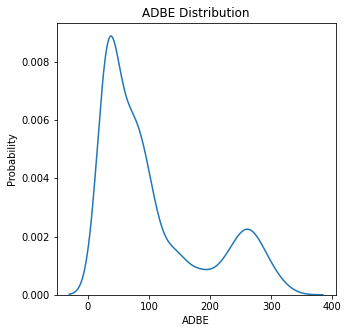

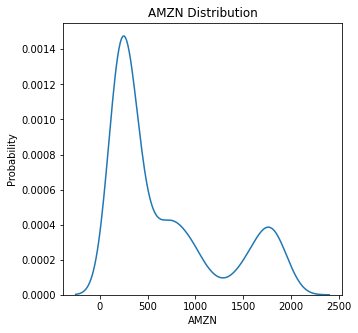

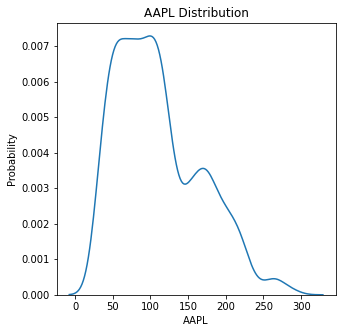

In [ ]:
# Distribution of each stock
for column in Stock_price.columns:
    plot_distribution(Stock_price, column)

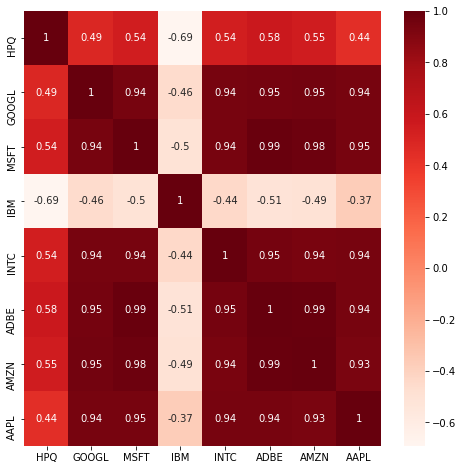

In [ ]:
# Calculate correlation coefficient
correlation = Stock_price.corr()

# Plot heatmap for correlation
plt.figure(figsize=(8,8))
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
plt.show()

Plot the time series data of some variables

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Year'), Text(0.5, 1.0, 'AAPLE')]

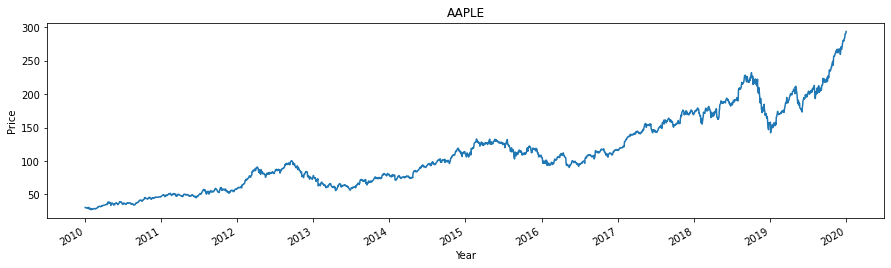

In [ ]:
# Plot AAPLE 2010 - 2019 
plt.figure(figsize=(15,4))
ax1 = Stock_price['AAPL']['2010-01-04':'2019-12-31'].plot()
ax1.set(xlabel='Year', ylabel='Price', title = "AAPLE")

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Year')]

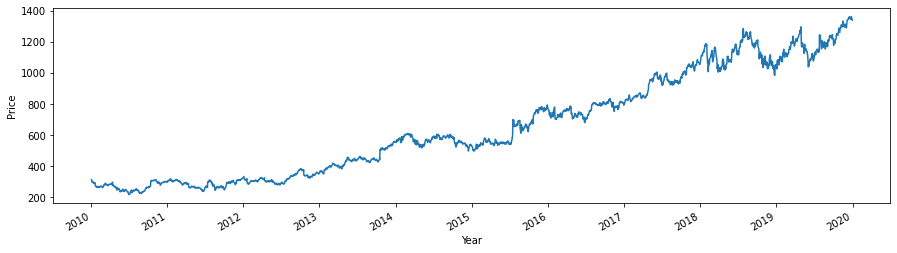

In [ ]:
# Plot GOOGL 2010 - 2019
plt.figure(figsize=(15,4))
ax1 = Stock_price['GOOGL']['2010-01-04':'2019-12-31'].plot()
ax1.set(xlabel='Year', ylabel='Price')

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Year'), Text(0.5, 1.0, 'INTC')]

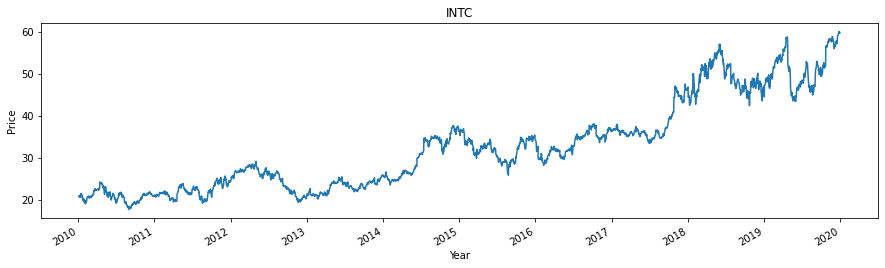

In [ ]:
# Plot INTC 2010 -2019
plt.figure(figsize=(15,4))
ax1 = Stock_price['INTC']['2010-01-04':'2019-12-31'].plot()
ax1.set(xlabel='Year', ylabel='Price', title="INTC")

**There are some conclusions:**
- No missing values or blank values
- All distributions are multimodal normal distribution, no extreme outliers
- 2 variables have weak relationship with AAPL: IBM (-0.37) and HPQ (0.44).
Others have very strong relations with AAPL (>= 0.93)


**In the next step, we do some process to prepare data for model construction**
- Target is Apple stock price - AAPL. The aim is to predict 2-days ahead, therefore, we shift the target two days backward to use as label.

- "Day" and "Date" are removed in preprocessing step as they are indicator. 
- All remaining variables are predictors


Then we split data into train/test sets (0.7/0.3) and rescale all to range (0,1)

-> Input data is ready for model construction in next part

In [ ]:
# First, prepare data for model.

# Target is Apple stock price - AAPL.
# The aim is to predict 2-days ahead, therefore, we shift the target two days backward to use as label.
# "Day" and "Date" are removed in preprocessing step as they are indicator. All remaining variables are predictors

target = ['AAPL']
horizon = 2
Apple = Stock_price[target].shift(-horizon)

# As data are shifted 2-days backward, some values from the beginning of target-values will drop off, and some at the end of target-values will become undefined.
# Show target label values - AAPL and compare with original series
original = pd.concat([Stock_price[target].head(horizon + 5)], keys=['Original series'], axis=1)
two_days_head = pd.concat([Apple.head(5)], keys=['Target Label Values'], axis=1)
display_side_by_side(original, two_days_head)

,Original series
,AAPL
Date,
2010-01-04,30.572857
2010-01-05,30.625713
2010-01-06,30.138571
2010-01-07,30.082857
2010-01-08,30.282858
2010-01-11,30.015715
2010-01-12,29.674286
,Target Label Values


In [ ]:
# Convert both label-values and predictors-values from Pandas Data-frame to Numpy array for input to the neural network. 
# Remove the last part of the numpy arrays, because the target-data has NaN for the shifted period to keep the same array-shapes for the input- and output-data.

# Correct predictors x and targets/labels y for the shifted period
x_data = Stock_price.values[0:-horizon] # x-data is predictors 
y_data = Apple.values[:-horizon] # y-data is label

# Calculate training and testing partition sizes (train/test - 0.7/0.3)
num_data = len(x_data)
train_split = 0.7
num_train = int(train_split * num_data)
num_test = num_data - num_train

# Define boundaries for training and testing
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

# Identify time events to be used in training
num_x_events = x_data.shape[1]
num_y_events = y_data.shape[1]

print("Original x shape:", x_data.shape, ", New x shape:", x_train.shape, x_test.shape)
print("Original y shape:", y_data.shape, ", New y shape:", y_train.shape, y_test.shape)

Original x shape: (2514, 8) , New x shape: (1759, 8) (755, 8)
Original y shape: (2514, 1) , New y shape: (1759, 1) (755, 1)


In [ ]:
# Rescale data values for both training and test data
print("Before train x scaling - Min:", np.min(x_train), ", Max:", np.max(x_train))
print("Before test x scaling - Min:", np.min(x_test), ", Max:", np.max(x_test))

x_scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
x_train_scaled = x_scaler.fit_transform(x_train).clip(0,1)
x_test_scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
x_test_scaled = x_test_scaler.fit_transform(x_test).clip(0,1)

print("After train x scaling - Min:", np.min(x_train_scaled), ", Max:", np.max(x_train_scaled))
print("After test x scaling - Min:", np.min(x_test_scaled), ", Max:", np.max(x_test_scaled))

Before train x scaling - Min: 5.317893028259277 , Max: 844.3599853515625
Before test x scaling - Min: 14.579999923706055 , Max: 2039.510009765625
After train x scaling - Min: 0.0 , Max: 1.0
After test x scaling - Min: 0.0 , Max: 1.0


In [ ]:
print("Before train y scaling - Min:", np.min(y_train), ", Max:", np.max(y_train))
print("Before test y scaling - Min:", np.min(y_test), ", Max:", np.max(y_test))

y_scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
y_train_scaled = y_scaler.fit_transform(y_train).clip(0,1)
y_test_scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
y_test_scaled = y_test_scaler.fit_transform(y_test).clip(0,1)

print("After train y scaling - Min:", np.min(y_train_scaled), ", Max:", np.max(y_train_scaled))
print("After test y scaling - Min:", np.min(y_test_scaled), ", Max:", np.max(y_test_scaled))

Before train y scaling - Min: 27.43571472167969 , Max: 133.0
Before test y scaling - Min: 115.81999969482422 , Max: 293.6499938964844
After train y scaling - Min: 0.0 , Max: 1.0
After test y scaling - Min: 0.0 , Max: 0.9999999999999999


<a id = "cell_model"></a>
## 3. Model Construction

In this section, we try different models (GRU, LSTM) with different parameters:
- different number of layers
- several activation functions 
- set up regularizer l1,l2
- BatchNormalization
- set up some optimizers ((Adam, Nadam, SGD, RMSprop)

For all models: Loss function = MSE, epochs = 100, steps_per_epoch = 60, warmup_steps = 7




In [ ]:
# As the training-data have more than 25000s of records, so instead of training the neural net on the complete sequences, 
# Create a batch-generator function to create batches of shorter sub-sequences randomly picked from training-data.

def batch_generator(batch_size, sequence_length):
    while True:
        # Allocate a new array for the batch of input-events.
        x_shape = (batch_size, sequence_length, num_x_events)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-events.
        y_shape = (batch_size, sequence_length, num_y_events)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [ ]:
#Process sequences before updating the model.
batch_size = 128

#The length of each time series sequences/input dimenions.
sequence_length = 42

# Create the batch-generator
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

# Test the batch-generator, which gives a random batch of 'batch_size' sequences, each sequence having 'sequence_length' observations.
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(128, 42, 8)
(128, 42, 1)


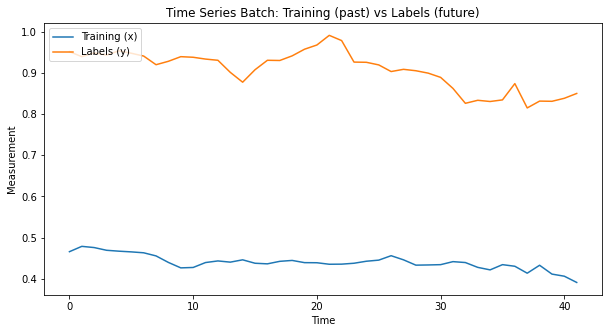

In [ ]:
# Plot one of the input-output events from batch-generator
batch = 0  # Some sequence in the batch
event = 0  # Some event from input-events
x_seq = x_batch[batch, :, event]
y_seq = y_batch[batch, :, event]
plt.plot(x_seq)
plt.plot(y_seq)
plt.title('Time Series Batch: Training (past) vs Labels (future)')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['Training (x)', 'Labels (y)'], loc='upper left')

In [ ]:
# Note: Model validation will be performned after each epoch and when the model improves its weights will be saved. For training, 
# we will use the batch-generator, however, for validation we will use the entire sequence, i.e. including x and y

# Next step is create validation set.
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Define neural network parameters
# set the number of epochs to be 100, steps_per_epoch to be 60 and warmup_steps to be 7
epochs = 100
steps_per_epoch = 60
warmup_steps = 7

In [ ]:
# Mean Squared Error (MSE) = loss-function.
# As the model will see input-events for a few time-steps only, so its generated output may be very inaccurate. 
# Using the standard loss function in the early time-steps may cause the model to distort its later output. 
# Therefore, give the model a "warmup-period" of warmup_steps time-steps where model's accuracy in the loss-function is not counted

# The shape of both input tensors are: [batch_size, sequence_length, num_y_events]
def loss_mse_warmup(y_true, y_pred):
    # Ignore the "warmup" parts of the sequences
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    mse = mean(square(y_true_slice - y_pred_slice))   
    return mse

In [ ]:
# Model 1 - GRU 
# def rnn_model_gru_2_layers(num_x_events, num_y_events):
#     model = Sequential()
#     model.add(GRU(units=512,
#                   return_sequences=True,
#                   input_shape=(None, num_x_events,), activation ="tanh"))
#     model.add(BatchNormalization())
#     model.add(GRU(units=256,
#                   return_sequences=True, activation ="tanh"))
#     model.add(BatchNormalization())
#     model.add(Dense(num_y_events, activation='sigmoid'))
#     model.summary()
#     return(model)

In [ ]:
# Model 2 - LSTM
# using "tanh" activation for hidden layers and "sigmoid" activation for output layer

def rnn_model_LSTM(num_x_events, num_y_events):
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), 
                   input_shape=(None, num_x_events,),activation ="tanh"))
    model.add(BatchNormalization())
    model.add(LSTM(units=150, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),activation ="tanh"))
    model.add(BatchNormalization())    
    model.add(Dense(num_y_events, activation='sigmoid'))
    model.summary()
    return(model)

In [ ]:
# Create Keras callbacks for save checkpoints and log the progress to TensorBoard during training model

path_checkpoint = './gru_checkpoints/'

callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
        monitor='val_loss',
        verbose=1,
        save_weights_only=True,
        save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
        patience=20, verbose=0)

callback_tensorboard = TensorBoard(log_dir='./gru_logs/',
        histogram_freq=0,
        write_graph=False)

# This callback reduces the learning-rate if the validation-loss has not improved as defined by `patience`.
# The learning-rate will be reduced by a `factor` (by multiplying) but no more than `min_lr`.
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
        factor=0.3,
        min_lr=1e-4,
        patience=5,
        min_delta = 1e-3,
        verbose=1)

keras_callbacks = [
        callback_early_stopping,
        #callback_tensorboard,
        callback_reduce_lr,
        callback_checkpoint]

In [ ]:
# Define a few popular optimizers to test

opt_sgd_1 = SGD(lr=0.01, momentum=0.1, nesterov=False)
opt_sgd_2 = SGD(lr=0.05, momentum=0.1, nesterov=False)

opt_rmsprop_1 = RMSprop(lr=0.005, rho=0.9, decay=0.05, epsilon=1e-07)
opt_rmsprop_2 = RMSprop(lr=0.001, rho=0.9, decay=0.1, epsilon=1e-07)

opt_adadelta_1 = Adadelta(lr=0.001, rho=0.95, epsilon=1e-07)
opt_adadelta_2 = Adadelta(lr=0.01, rho=0.99, epsilon=1e-07)

opt_adam_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
opt_adam_2 = Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07)

opt_nadam = Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Model architecture summary

# Start collecting history, in case we train the model iteratively
rnn_hist = start_hist()

model = rnn_model_LSTM(num_x_events, num_y_events)
model.compile(loss=loss_mse_warmup, 
              optimizer = opt_rmsprop_2, # opt_rmsprop_2 = RMSprop(lr=0.001, rho=0.9, decay=0.1, epsilon=1e-07)
              metrics=[metrics.mae])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 150)         95400     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 150)         600       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 150)         180600    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 150)         600       
_________________________________________________________________
dense (Dense)                (None, None, 1)           151       
Total params: 277,351
Trainable params: 276,751
Non-trainable params: 600
_________________________________________________________________


After several test, we create a RNN-LSTM model with 2 LSTM layers and 1 Dense output layer:

- l2 regularizer
- activation function for hidden layers: tanh
- activation function of ouput: sigmoid
- 2 batch normalization
- Loss function = MSE, epochs = 100, steps_per_epoch = 60, warmup_steps = 7
- Callbacks metric = MAE


<a id = "cell_execution"></a>
## 4. Model Execution

In this section:
- Fit model
- Record and plot the history of training and validation. 
- Report the performance (MAE and loss-MSE) of model on the both the training and the test data

In [ ]:
# Fit model to training data
%%time
perform_indics = model.fit(x=generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data,
        callbacks=keras_callbacks,
        verbose=2)

# Collect performance history
rnn_hist = collect_hist(rnn_hist, perform_indics.history)

Epoch 1/100
60/60 - 13s - loss: 3.1266 - mean_absolute_error: 0.0866 - val_loss: 2.3337 - val_mean_absolute_error: 0.1718

Epoch 00001: val_loss improved from inf to 2.33367, saving model to ./gru_checkpoints/
Epoch 2/100
60/60 - 2s - loss: 1.9849 - mean_absolute_error: 0.0503 - val_loss: 1.7769 - val_mean_absolute_error: 0.1661

Epoch 00002: val_loss improved from 2.33367 to 1.77691, saving model to ./gru_checkpoints/
Epoch 3/100
60/60 - 2s - loss: 1.5862 - mean_absolute_error: 0.0470 - val_loss: 1.4860 - val_mean_absolute_error: 0.1622

Epoch 00003: val_loss improved from 1.77691 to 1.48599, saving model to ./gru_checkpoints/
Epoch 4/100
60/60 - 2s - loss: 1.3539 - mean_absolute_error: 0.0446 - val_loss: 1.2954 - val_mean_absolute_error: 0.1533

Epoch 00004: val_loss improved from 1.48599 to 1.29544, saving model to ./gru_checkpoints/
Epoch 5/100
60/60 - 2s - loss: 1.1958 - mean_absolute_error: 0.0454 - val_loss: 1.1584 - val_mean_absolute_error: 0.1439

Epoch 00005: val_loss improve

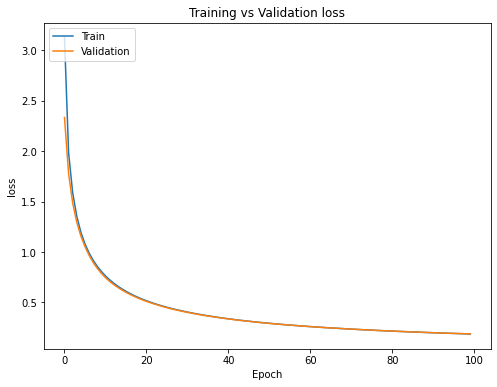

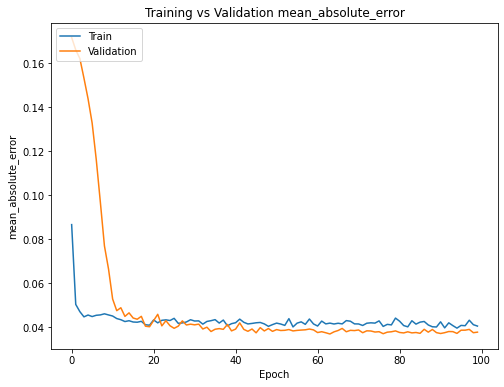

In [ ]:
# Plot training performance
plot_hist(rnn_hist, xsize=8, ysize=6)

In [ ]:
# # As we used ModelCheckpoint callback, we can reload the last saved checkpoint, which had the best performance on the validation set.
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
#Training performance
result = model.evaluate(x=np.expand_dims(x_train_scaled, axis=0),
                        y=np.expand_dims(y_train_scaled, axis=0))
# We have several metrics so we want to show their names
print()
for res, metric in zip(result, model.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 1s/step - loss: 0.1871 - mean_absolute_error: 0.0218

loss: 0.18706
mean_absolute_error: 0.02176


In [ ]:
#Test performance
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
# We have several metrics so we want to show their names
print()
for res, metric in zip(result, model.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 0s 83ms/step - loss: 0.1884 - mean_absolute_error: 0.0377

loss: 0.18842
mean_absolute_error: 0.03765


**Model Performance**

|MODEL         | Train_Loss |Test_Loss |Train_MAE|Test_MAE|
|        :-    |     :-     |    :-    |   :-    |   :-   |
|LSTM - RMSprop|  0.18706   |  0.18842 | 0.02176 | 0.03765|

From 2 graphs: 

- Training vs Validation - loss: very good fit

- Training vs Validation - MAE:  about first 20 epochs, the model is undertrain. After that, it is quite a good fit. There is small gap between train and validation results.

<a id = "cell_report"></a>
## 5. Prediction

In this section:
plot the predicted and true output time-series of AAPL price

In [ ]:
# Plot the predicted and true output-events.

def plot_comparison(start_idx, length=100, train=True, xlim=None, ylim=None):
    """
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-events for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-events.
    y_pred = model.predict(x)
    
    # The output of the model is scaled.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    if train:
        y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    else:
        y_pred_rescaled = y_test_scaler.inverse_transform(y_pred[0])
    
    # For each output-event.
    for event in range(len(target)):
        # Get the output-event predicted by the model.
        event_pred = y_pred_rescaled[:, event]
        
        # Get the true output-event from the data-set.
        event_true = y_true[:, event]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two events.
        plt.plot(event_true, label='true')
        plt.plot(event_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        if (xlim): plt.xlim(xlim)
        if (ylim): plt.ylim(ylim)
        plt.ylabel(target[event])
        plt.legend()
        plt.show()

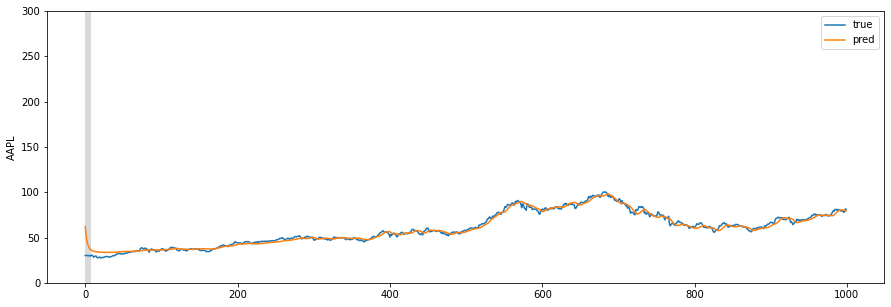

In [ ]:
# Example from the training data
plot_comparison(start_idx=0, length=1000, train=True, ylim=(0,300))

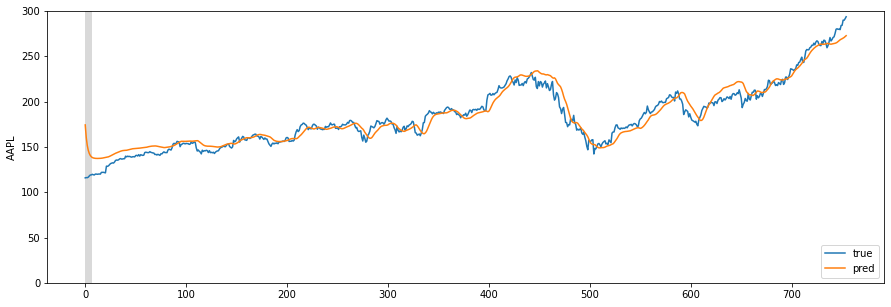

In [ ]:
# Example from test data
plot_comparison(start_idx=0, length=1000, train=False, ylim=(0, 300))

### **SUMMARY**

**What is Deep Learning ?**

Deep learning is a subset of ML, which is basically neural network , consisting of two or more layers. These neural networks try to simulate the behavior of the human brain, allowing it to “learn” from large amounts of data. 




**How deep learning works ?**

Forward propagation: Deep neural networks consist of multiple layers of nodes, which build on the previous layer to refine and optimize the outcome.

Backpropagation: Deep neural networks uses algorithms (e.g: gradient descent) to calculate errors in predictions and then adjusts the weights and biases of the function in each layer

In general, deep learning algorithms are very complex, and have different types to solve particular problems or datasets. Two popular types:

- Convolutional neural networks (CNNs): widely used in computer vision and image classification applications

- Recurrent neural network (RNNs) are typically used in natural language and speech recognition applications or dealing with times series data.

**Deep learning methods**

Various methods can be used to create strong deep learning models, such as:
- learning rate decay
- transfer learning
- training from scratch
- dropout.



**Deep Learning vs Machine Learning**

Deep Learning:
- creates algorithms in layers to make an “artificial neural network” that can learn and make intelligent decisions on its own
- Need large data sets, can work with both structured and unstructured data
- Takes longer time to train, normally require GPU for faster and better performance
- Results can be in any form including free form elements (free text, sound)
- Model structures can be adjusted and tuned in various ways
- Less human in the loop
- require costly, high-end machines and high-performing GPUs 


Machine learning:
- uses algorithms to process and learn from that data, then make informed decisions based on what it learns
- Can train on smaller datasets, prefer structured data
- Take less time to train
- Results should be numerical
- Limited tuning capability for hyperparameter
- More human in the loop


**Application of Deep Learning**

- Customer experience
- Text translations, text generation
- Language recognition 
- Auto vehicles
- Computer vision:  image classification, object detection, image restoration and image segmentation
- Virtual assistant
- Fraud detection


**References**

IBM Cloud Education 2020, Deep Learning. https://www.ibm.com/cloud/learn/deep-learning

Chatterjee M. 2019, Top 20 Applications of Deep Learning in 2021 Across Industries. https://www.mygreatlearning.com/blog/deep-learning-applications/

Advani V. 2021, What is the Difference Between Machine Learning and Deep Learning. https://www.mygreatlearning.com/blog/deep-learning-vs-machine-learning/#dl

Marr B. n.d, 10 Amazing Examples Of How Deep Learning AI Is Used In Practice?
https://bernardmarr.com/10-amazing-examples-of-how-deep-learning-ai-is-used-in-practice/
